In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

In [4]:
from DeepSVR.analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from DeepSVR.analysis_utils.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [5]:
# Pull in training data
training_data = pd.read_pickle('DeepSVR/data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [6]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [7]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [8]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [9]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [10]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [11]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [12]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [13]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [14]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [15]:
# Set parameters
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

#### Select K value

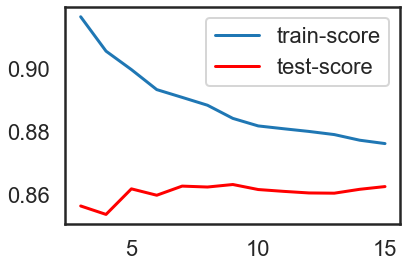

In [15]:
score_train = []
score_test = []

for i in np.arange(3,16):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    sc_train = knn.score(X_train, Y_train)
    sc_test = knn.score(X_test, Y_test)
    score_train.append(sc_train)
    score_test.append(sc_test)

plt.plot(np.arange(3,16), score_train, label='train-score')
plt.plot(np.arange(3,16), score_test, label='test-score', color='red')
plt.legend()

In [16]:
# Set parameters for the estimator
estimator = KNeighborsClassifier(n_neighbors=9)

In [17]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [18]:
# Save the probabilities in /data folder
np.save('DeepSVR/data/knn.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [20]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8584637786676375

Cross validation classification report

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      7189
           1       0.89      0.90      0.90      8015
           2       0.86      0.92      0.89     12266

   micro avg       0.86      0.86      0.86     27470
   macro avg       0.85      0.84      0.85     27470
weighted avg       0.86      0.86      0.86     27470
 samples avg       0.86      0.86      0.86     27470



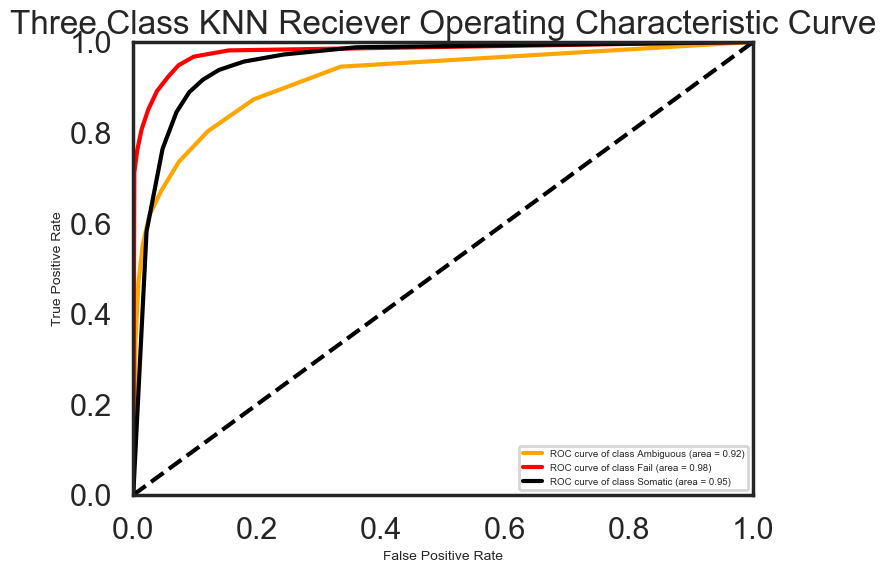

In [20]:
# Plot ROC for Random Forest Model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class KNN Reciever Operating Characteristic Curve', ax)

C:\Users\minie\Desktop\week6\DeepSVR\analysis_utils\ClassifierPlots.py:67: RuntimeWarning: invalid value encountered in true_divide
  pct_positive = positive_counts / (positive_counts + negative_counts)
C:\Users\minie\Desktop\week6\DeepSVR\analysis_utils\ClassifierPlots.py:77: RuntimeWarning: divide by zero encountered in true_divide
  inverse_n = 1/(positive_counts+negative_counts)
C:\Users\minie\Desktop\week6\DeepSVR\analysis_utils\ClassifierPlots.py:78: RuntimeWarning: invalid value encountered in multiply
  con_ints = z * np.sqrt(inverse_n * pct_positive * pct_negative)


confidence intervals +-:  [       nan 0.00399778 0.00657892 0.00864463 0.01007014 0.01077135
 0.01019299 0.00819276 0.00524178 0.00127423]


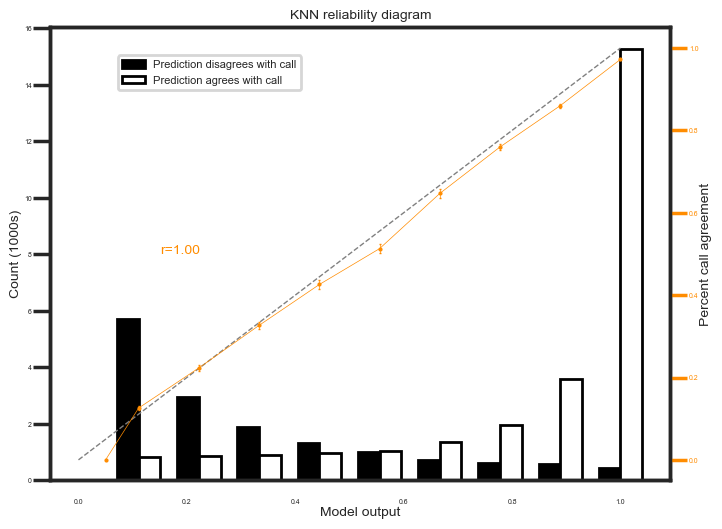

In [21]:
# Plot reliability diagram for Random Forest Model
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot, ['Ambiguous','Fail','Somatic'], 'darkorange', 'KNN reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [28]:
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [29]:
def create_feature_importance_plot(feature_importance, save_fp='DeepSVR/data/knn_feature_import.pkl'):
    feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,feature_importance]).T
    feature_import.columns = ['feature', 'importance']
    summed_importances = []
    for label in ['disease', 'reviewer']:
        summed_importances.append([label, sum_features(feature_import, label)])
    summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
    feature_import.to_pickle(save_fp)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
    sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('KNN feature importance')

In [30]:
# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [21]:
knn_fit = estimator.fit(X_train, Y_train)
results = permutation_importance(knn_fit, X_train, Y_train, scoring='accuracy')

In [32]:
results = permutation_importance(knn_fit, X_train, Y_train, scoring='accuracy')

In [33]:
knn_fit = estimator.fit(X_train, Y_train)
results = permutation_importance(knn_fit, X_train, Y_train, scoring='accuracy')
importance = results.importances_mean
importance

array([ 4.73971605e-03, -1.09210047e-04,  4.14998180e-04,  5.31488897e-04,
        2.23516564e-03,  3.20349472e-04,  3.64033491e-05,  1.82016746e-03,
        1.09210047e-04,  2.52639243e-03, -2.18420095e-05,  0.00000000e+00,
        3.64033491e-04,  7.13505643e-04, -1.45613396e-05,  2.00218420e-03,
        5.40953768e-03,  3.13068802e-04,  7.13505643e-04,  2.46741900e-02,
        3.64033491e-05, -6.66133815e-17,  2.32981434e-04,  5.09646888e-05,
       -5.82453586e-05,  8.24899891e-03,  2.32981434e-04,  7.13505643e-04,
        2.40262104e-03,  1.03094285e-02,  1.89297415e-04,  2.31525300e-03,
        2.54823444e-04, -7.28066982e-05, -2.91226793e-05,  7.28066982e-06,
        0.00000000e+00,  7.28066982e-05,  1.09210047e-03,  1.35420459e-03,
        4.36840189e-04, -1.09210047e-04,  8.26865672e-02,  3.64033491e-05,
       -7.28066982e-06,  1.81288679e-03,  2.91226793e-04,  1.61630870e-03,
        2.02402621e-03,  5.56243174e-03,  2.18420095e-04,  8.22715690e-04,
        1.07025846e-03,  

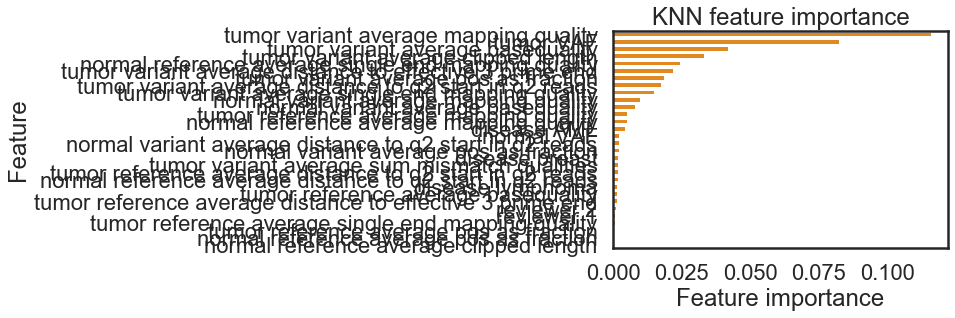

In [34]:
# Plot feature importance graph
create_feature_importance_plot(importance)

### Test set performance

In [22]:
# Determine performance on test set
test_prob = knn_fit.predict_proba(X_test)

In [23]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

In [24]:
test_prob

array([[1.        , 0.        , 0.        ],
       [0.22222222, 0.44444444, 0.33333333],
       [0.66666667, 0.11111111, 0.22222222],
       ...,
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.66666667, 0.11111111, 0.22222222]])

In [25]:
print_accuracy_and_classification_report(Y_test_labels, predict_classes(test_prob))

Cross validation accuracy:
	 0.8607538802660754

Cross validation classification report

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      3454
           1       0.89      0.90      0.90      3961
           2       0.87      0.92      0.89      6115

   micro avg       0.86      0.86      0.86     13530
   macro avg       0.86      0.84      0.85     13530
weighted avg       0.86      0.86      0.86     13530
 samples avg       0.86      0.86      0.86     13530



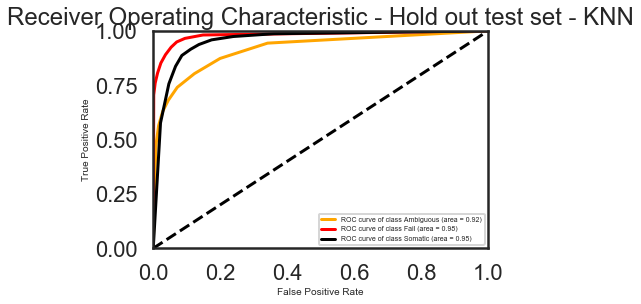

In [37]:
# Plot AUC for test set
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'KNN', ax)

C:\Users\minie\Desktop\week6\DeepSVR\analysis_utils\ClassifierPlots.py:67: RuntimeWarning: invalid value encountered in true_divide
  pct_positive = positive_counts / (positive_counts + negative_counts)
C:\Users\minie\Desktop\week6\DeepSVR\analysis_utils\ClassifierPlots.py:77: RuntimeWarning: divide by zero encountered in true_divide
  inverse_n = 1/(positive_counts+negative_counts)
C:\Users\minie\Desktop\week6\DeepSVR\analysis_utils\ClassifierPlots.py:78: RuntimeWarning: invalid value encountered in multiply
  con_ints = z * np.sqrt(inverse_n * pct_positive * pct_negative)


confidence intervals +-:  [       nan 0.00554458 0.0091734  0.01214576 0.01464365 0.01541561
 0.01406411 0.01168395 0.00714828 0.00186045]


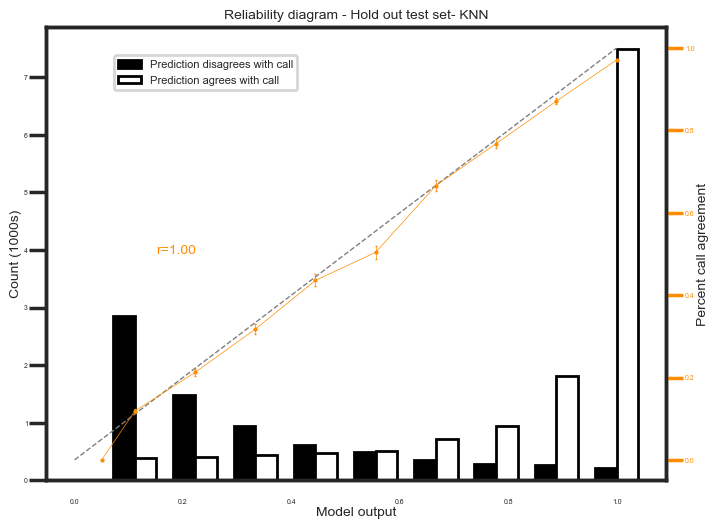

In [38]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- KNN',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))